In [9]:
import sqlite3
from sqlite3 import Error
import os.path
from os import path

from create_db import create_connection, create_table, clean_column_names
from populate_db import extract_data, insert_records
import query_db as qd
import config
import build_dataset as build
import pipeline
import classification

import importlib
import datetime
import re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline

# Notebook table of contents:
1. Run all models for binary outcome variable. Run the best model according to F1 score and precision, predict on test data, calculate evaluation metrics
2. Repeat 1 without using demographic features
3. Repeat 1-2 on three-class outcome variable
4. Repeat 1-2 on 6-class outcome variable

In [2]:
# Import data
dataset_3 = pd.read_csv('../data/dataset_main_active3.csv')

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,22,29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
target = config.target_vars[0]

In [51]:
# Step 1
target_type = "binary"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)


# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  32711
Dataset size:  773724


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Total Number of Unique IDs: 418845
Total Number of IDs in Test Data: 83769
Total Number of IDs in Train Data: 268061
Total Number of IDs in Validate Data: 67015
Do the IDs add up? True
Does Test Represent 20% of the data? True
Test Represents X% of the data: 0.2
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8
Does Validate Represent 20% of the Train+Validate Data?: 0.19999940312048609
Does Train Represent 80% of the Train+Validate Data?: 0.8000005968795139


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')
Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [52]:
target = config.target_vars[0]
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,84922,84922,84922,84922,84922,84922,84922,84922,84922,84922,...,84922,84922,84922,84922,84922,84922,84922,84922,84922,84922
1.0,39206,39206,39206,39206,39206,39206,39206,39206,39206,39206,...,39206,39206,39206,39206,39206,39206,39206,39206,39206,39206


In [53]:
# train_backup = train_data.copy()
# validate_backup = validate_data.copy()
# test_backup = test_data.copy()


In [54]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

In [20]:
importlib.reload(build)
importlib.reload(config)
importlib.reload(pipeline)
importlib.reload(classification)

<module 'classification' from '/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/classification.py'>

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore th

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


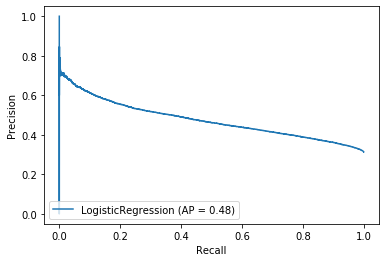

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[74609 31467]
 [22505 26040]]
Accuracy:	0.6509400404860918
Precision:	0.4528144399812197
Recall:		0.5364095169430425
F1 Score:	0.49107984762192125

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitt

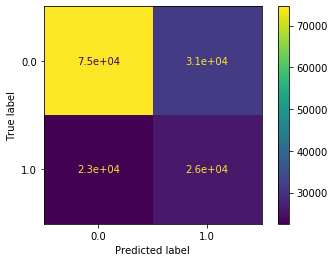

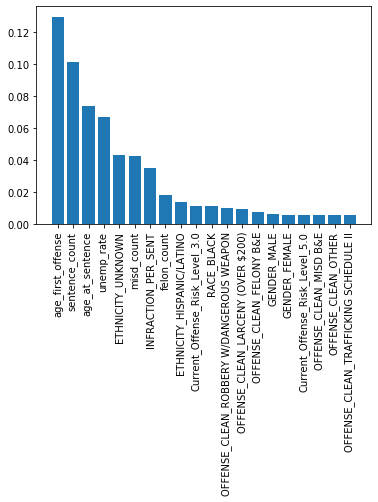

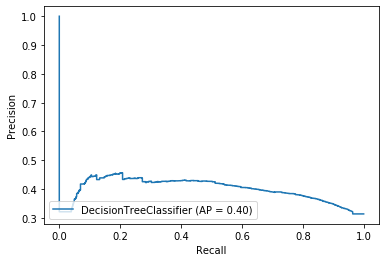

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[79412 26664]
 [28326 20219]]
Accuracy:	0.6443561999987065
Precision:	0.4312650640957277
Recall:		0.4165001544958286
F1 Score:	0.42375403445529614

{'criterion': ('gini', 'entropy'), 'n_estimators': (100, 1000, 5000), 'max_depth': (10, 20, 30, None), 'min_samples_split': (5, 50, 100)}
Running:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decreas

KeyboardInterrupt: 

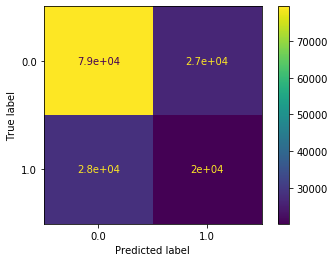

In [58]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features)

best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)

In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 2
target_type = "binary"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [11]:
# Step 3
target_type = "three_class"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  27486
Dataset size:  224981


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Total Number of Unique IDs: 164194
Total Number of IDs in Test Data: 32839
Total Number of IDs in Train Data: 105084
Total Number of IDs in Validate Data: 26271
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.2000012180713059
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999987819286941
Does Validate Represent 20% of the Train+Validate Data?: 0.2
Does Train Represent 80% of the Train+Validate Data?: 0.8


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')
Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [12]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,31301,31301,31301,31301,31301,31301,31301,31301,31301,31301,...,31301,31301,31301,31301,31301,31301,31301,31301,31301,31301
1.0,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170,...,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170
2.0,723,723,723,723,723,723,723,723,723,723,...,723,723,723,723,723,723,723,723,723,723


In [13]:
# train_backup = train_data.copy()
# validate_backup = validate_data.copy()
# test_backup = test_data.copy()


In [14]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

In [22]:
# train_data = train_backup
# validate_data = validate_backup
# test_data = test_backup

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[38930    43     1]
 [ 5118    33     0]
 [  867     5     1]]
Accuracy:	0.8659051513400595
Precision:	0.5913852365854295
Recall:		0.33547434687026834
F1 Score:	0.3143438714010158

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprec

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


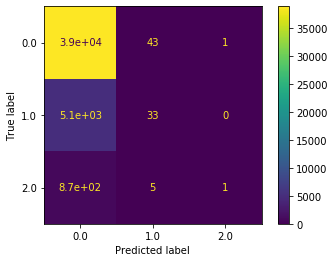

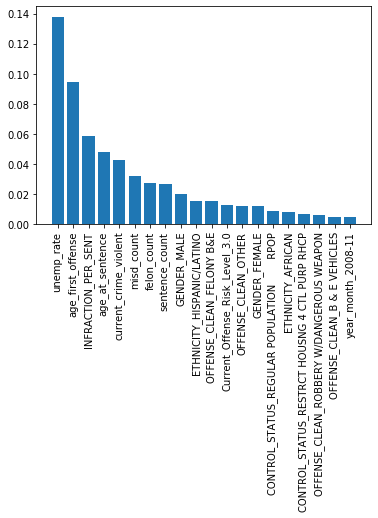

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[38281   643    50]
 [ 4952   191     8]
 [  846    25     2]]
Accuracy:	0.8550157784790435
Precision:	0.3747161151896264
Recall:		0.34053001484162454
F1 Score:	0.3298976881433949

Time Elapsed: 0:08:17.376337


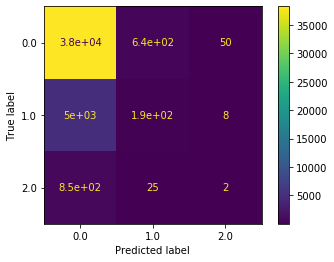

In [23]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [24]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",2,1,2,1,0.868023,0.333503,0.310074,0.311767
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",1,2,1,2,0.869940,0.333366,0.401091,0.310215
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.855967,0.334604,0.333326,0.319983
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.867885,0.334075,0.339935,0.313005


In [26]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.865905,0.591385,0.335474,0.314344
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.855016,0.374716,0.340530,0.329898


In [27]:
# Step 3
target_type = "three_class"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  27486
Dataset size:  224981


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Total Number of Unique IDs: 164194
Total Number of IDs in Test Data: 32839
Total Number of IDs in Train Data: 105084
Total Number of IDs in Validate Data: 26271
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.2000012180713059
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999987819286941
Does Validate Represent 20% of the Train+Validate Data?: 0.2
Does Train Represent 80% of the Train+Validate Data?: 0.8


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix',
       'Recidivate_Risk_Level', 'age_cat', 'age_first_offense',
       'juv_first_offense', 'current_crime_violent'],
      dtype='object')
Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [28]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,31301,31301,31301,31301,31301,31301,31301,31301,31301,31301,...,31301,31301,31301,31301,31301,31301,31301,31301,31301,31301
1.0,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170,...,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170
2.0,723,723,723,723,723,723,723,723,723,723,...,723,723,723,723,723,723,723,723,723,723


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[38926    47     1]
 [ 5117    34     0]
 [  867     5     1]]
Accuracy:	0.8658384817102982
Precision:	0.5873681902996346
Recall:		0.335504848382441
F1 Score:	0.3144538069802378

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecat

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


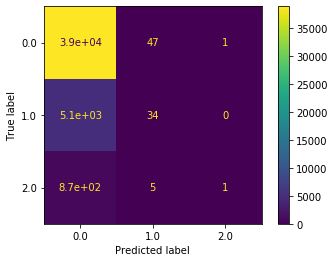

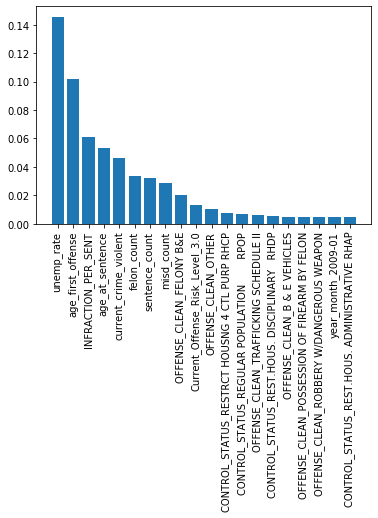

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[38301   630    43]
 [ 4967   176     8]
 [  842    29     2]]
Accuracy:	0.8551268945286458
Precision:	0.37227359954383205
Recall:		0.33973038374487824
F1 Score:	0.32836870066420865

Time Elapsed: 0:07:05.720445


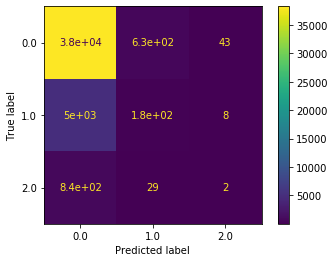

In [30]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [31]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,2,1,0.868173,0.333444,0.309386,0.311546
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,1,2,0.869930,0.333333,0.289977,0.310147
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.855141,0.334920,0.336013,0.321005
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.867848,0.334589,0.368193,0.314154


In [32]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.865838,0.587368,0.335505,0.314454
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.855127,0.372274,0.339730,0.328369


In [33]:
# Step 4
target_type = "all"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  27486
Dataset size:  224981
Total Number of Unique IDs: 164194
Total Number of IDs in Test Data: 32839
Total Number of IDs in Train Data: 105084
Total Number of IDs in Validate Data: 26271
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.2000012180713059
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999987819286941
Does Validate Represent 20% of the Train+Validate Data?: 0.2
Does Train Represent 80% of the Train+Validate Data?: 0.8


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['Recidivate_Risk_Level', 'RACE', 'GENDER', 'ETHNICITY',
       'CONTROL_STATUS', 'OFFENSE_CLEAN', 'Current_Offense_Risk_Level',
       'year_month', 'INFRACTION_PER_SENT', 'misd_count', 'felon_count',
       'sentence_count', 'age_at_sentence', 'unemp_rate', 'ID',
       'COMMITMENT_PREFIX', 'BIRTH_DATE', 'EARLIEST_SENTENCE_EFFECTIVE_DT',
       'END_DATE', 'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'age_cat',
       'age_first_offense', 'juv_first_offense', 'current_crime_violent'],
      dtype='object')


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [34]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,27450,27450,27450,27450,27450,27450,27450,27450,27450,27450,...,27450,27450,27450,27450,27450,27450,27450,27450,27450,27450
1.0,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,...,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024
2.0,1827,1827,1827,1827,1827,1827,1827,1827,1827,1827,...,1827,1827,1827,1827,1827,1827,1827,1827,1827,1827
3.0,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170,...,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170
4.0,609,609,609,609,609,609,609,609,609,609,...,609,609,609,609,609,609,609,609,609,609
5.0,114,114,114,114,114,114,114,114,114,114,...,114,114,114,114,114,114,114,114,114,114


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision i

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[34109     6     6    87     1     0]
 [ 2397     2     5    28     0     0]
 [ 2293     0     6    34     0     0]
 [ 5037     2     5   107     0     0]
 [  729     0     1    10     0     0]
 [  128     0     0     5     0     0]]
Accuracy:	0.7605671363171697
Precision:	0.26981465080809597
Recall:		0.17020727042510886
F1 Score:	0.1517986215880464



/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


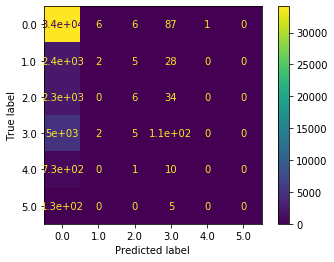

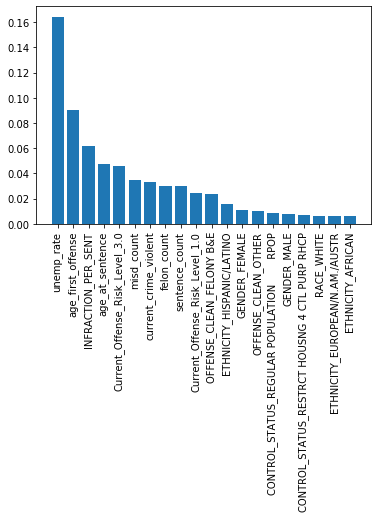

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[33320   180   177   499    29     4]
 [ 2316    31    21    62     2     0]
 [ 2193    36    33    67     4     0]
 [ 4804    46    47   246     8     0]
 [  707     5     3    23     2     0]
 [  126     0     0     7     0     0]]
Accuracy:	0.7474109960442686
Precision:	0.21743484679807845
Recall:		0.17522744912279073
F1 Score:	0.1653739473821265

Time Elapsed: 0:20:24.388873


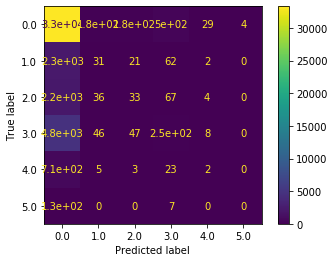

In [35]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [36]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,1,1,0.765359,0.180159,0.204097,0.159203
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,2,2,0.764675,0.177778,0.149859,0.154103
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",1,2,2,1,0.749646,0.176429,0.223953,0.163033
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",2,1,1,2,0.761373,0.178609,0.188985,0.157090


In [37]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.760567,0.269815,0.170207,0.151799
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.747411,0.217435,0.175227,0.165374


In [38]:
# Step 4
target_type = "all"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

248
Size of active sentences dataset:  27486
Dataset size:  224981
Total Number of Unique IDs: 164194
Total Number of IDs in Test Data: 32839
Total Number of IDs in Train Data: 105084
Total Number of IDs in Validate Data: 26271
Do the IDs add up? True
Does Test Represent 20% of the data? False
Test Represents X% of the data: 0.2000012180713059
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.7999987819286941
Does Validate Represent 20% of the Train+Validate Data?: 0.2
Does Train Represent 80% of the Train+Validate Data?: 0.8


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['Recidivate_Risk_Level', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'age_cat',
       'age_first_offense', 'juv_first_offense', 'current_crime_violent'],
      dtype='object')


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [39]:
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,CONTROL_STATUS_HIGH SECURITY/MAX CONTROL HCON,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,27450,27450,27450,27450,27450,27450,27450,27450,27450,27450,...,27450,27450,27450,27450,27450,27450,27450,27450,27450,27450
1.0,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024,...,2024,2024,2024,2024,2024,2024,2024,2024,2024,2024
2.0,1827,1827,1827,1827,1827,1827,1827,1827,1827,1827,...,1827,1827,1827,1827,1827,1827,1827,1827,1827,1827
3.0,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170,...,4170,4170,4170,4170,4170,4170,4170,4170,4170,4170
4.0,609,609,609,609,609,609,609,609,609,609,...,609,609,609,609,609,609,609,609,609,609
5.0,114,114,114,114,114,114,114,114,114,114,...,114,114,114,114,114,114,114,114,114,114


Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision i

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance
Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[34131     1     6    70     1     0]
 [ 2400     3     4    25     0     0]
 [ 2295     0     7    31     0     0]
 [ 5057     2     4    88     0     0]
 [  731     0     1     8     0     0]
 [  128     0     0     5     0     0]]
Accuracy:	0.7606782523667719
Precision:	0.3281145501193896
Recall:		0.16983965681398938
F1 Score:	0.1509573300316073

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_de

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/daminisharma/miniconda3/lib/python3.7/s

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_split': 100}
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
Recidivate_Risk_Level
Fitting best model
Feature Importance


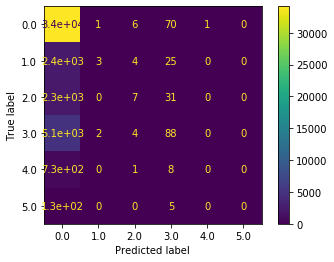

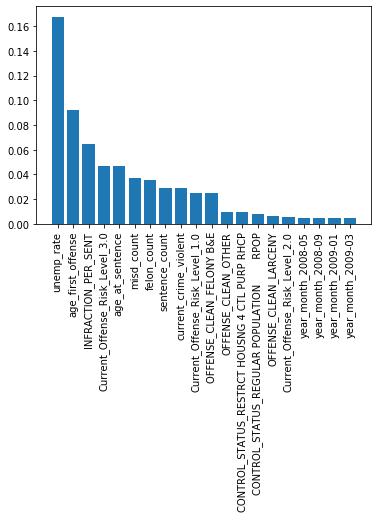

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[33282   157   136   599    34     1]
 [ 2307    26    20    74     5     0]
 [ 2202    18    33    74     6     0]
 [ 4833    32    34   248     4     0]
 [  709     7     3    19     2     0]
 [  120     0     4     9     0     0]]
Accuracy:	0.7464998444375306
Precision:	0.2165637548026812
Recall:		0.1747643715025443
F1 Score:	0.1646174412125793

Time Elapsed: 0:20:03.088643


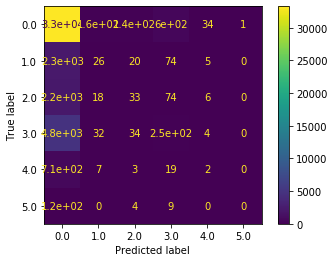

In [40]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type,features)
#best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
#results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [41]:
results

,classifier,params,rank_test_precision,rank_test_recall,rank_test_accuracy,rank_test_f1,mean_test_accuracy,mean_test_recall,mean_test_precision,mean_test_f1
1,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}",1,1,2,1,0.764092,0.178197,0.179841,0.155289
0,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}",2,2,1,2,0.764675,0.177778,0.149859,0.154103
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 30, 'min...",2,1,2,1,0.753051,0.180503,0.194127,0.163549
0,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...","{'criterion': 'entropy', 'max_depth': 10, 'min...",1,2,1,2,0.762706,0.179831,0.237418,0.159209


In [42]:
best_models

,classifier,test_accuracy,test_precision,test_recall,test_f1
0,"LogisticRegression(C=0.01, class_weight=None, ...",0.760678,0.328115,0.169840,0.150957
1,"DecisionTreeClassifier(ccp_alpha=0.0, class_we...",0.746500,0.216564,0.174764,0.164617
